In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import ADASYN
import joblib

In [2]:
# Load the data
df = pd.read_excel("C:/Users/baner/Documents/Planet-Hunt/data/Study_of_exoplanets.xlsx")

# Data preprocessing
feature_columns = ['P_MASS', 'P_RADIUS', 'P_PERIOD', 'P_SEMI_MAJOR_AXIS', 'P_TEMP_EQUIL', 'S_LUMINOSITY']
target_column = 'P_HABITABLE'

# Data preprocessing
for col in feature_columns:
     df.fillna({col: df[col].median()}, inplace=True)

df_cleaned = df[feature_columns + [target_column]]

# Display the cleaned DataFrame
print(df_cleaned.head())

       P_MASS  P_RADIUS    P_PERIOD  P_SEMI_MAJOR_AXIS  P_TEMP_EQUIL  \
0  6165.86330   2.33168   326.03000               1.29     799.44963   
1  4684.78480   2.33168   516.21997               1.53     819.07569   
2  1525.57440   2.33168   185.84000               0.83     772.30746   
3  1481.07850   2.33168  1773.40000               2.93     131.38424   
4   565.73385   2.33168   798.50000               1.66     202.22783   

   S_LUMINOSITY  P_HABITABLE  
0    163.546800            0  
1    250.492940            0  
2     58.175144            0  
3      0.629171            0  
4      1.250596            0  


In [3]:
# Features and target variable
X = df_cleaned[['P_MASS', 'P_RADIUS', 'P_PERIOD', 'P_SEMI_MAJOR_AXIS', 'P_TEMP_EQUIL', 'S_LUMINOSITY']]
y = df_cleaned['P_HABITABLE']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply ADASYN to the training data
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_scaled, y_train)

# Compute class weights
class_weights = dict(enumerate(compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)))

# DL model
model = keras.Sequential([
    # Input layer
    keras.layers.InputLayer(shape=(X_train_resampled.shape[1],)),

    # Hidden layers
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(16, activation='relu'),

    # Output layer
    keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])


# Train the model
history = model.fit(X_train_resampled, y_train_resampled, 
                    validation_split=0.2, 
                    epochs=80, 
                    batch_size=32,
                    class_weight=class_weights)

Epoch 1/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5969 - loss: 0.8161 - val_accuracy: 0.6220 - val_loss: 1.0143
Epoch 2/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8966 - loss: 0.2984 - val_accuracy: 0.5355 - val_loss: 1.0639
Epoch 3/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9334 - loss: 0.2166 - val_accuracy: 0.6783 - val_loss: 0.7937
Epoch 4/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9468 - loss: 0.1816 - val_accuracy: 0.7044 - val_loss: 0.8103
Epoch 5/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9509 - loss: 0.1582 - val_accuracy: 0.7539 - val_loss: 0.6669
Epoch 6/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9593 - loss: 0.1353 - val_accuracy: 0.7774 - val_loss: 0.5490
Epoch 7/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9596 - loss: 0.1332 - val_accuracy: 0.8441 - val_loss: 0.2845
Epoch 8/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9610 - loss: 0.1298 - val_accuracy: 0.

In [4]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f"Test accuracy: {test_acc:.4f}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - accuracy: 0.9941 - loss: 0.0286
Test accuracy: 0.9914


In [5]:
# Generate a classification report
y_pred = np.argmax(model.predict(X_test_scaled), axis=1)
print(classification_report(y_test, y_pred, target_names=['Uninhabitable Planets', 'Conservatively Habitable Planets', 'Optimistically Habitable Planets']))

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
                                  precision    recall  f1-score   support

           Uninhabitable Planets       1.00      1.00      1.00       799
Conservatively Habitable Planets       0.43      0.75      0.55         4
Optimistically Habitable Planets       0.50      0.29      0.36         7

                        accuracy                           0.99       810
                       macro avg       0.64      0.68      0.64       810
                    weighted avg       0.99      0.99      0.99       810



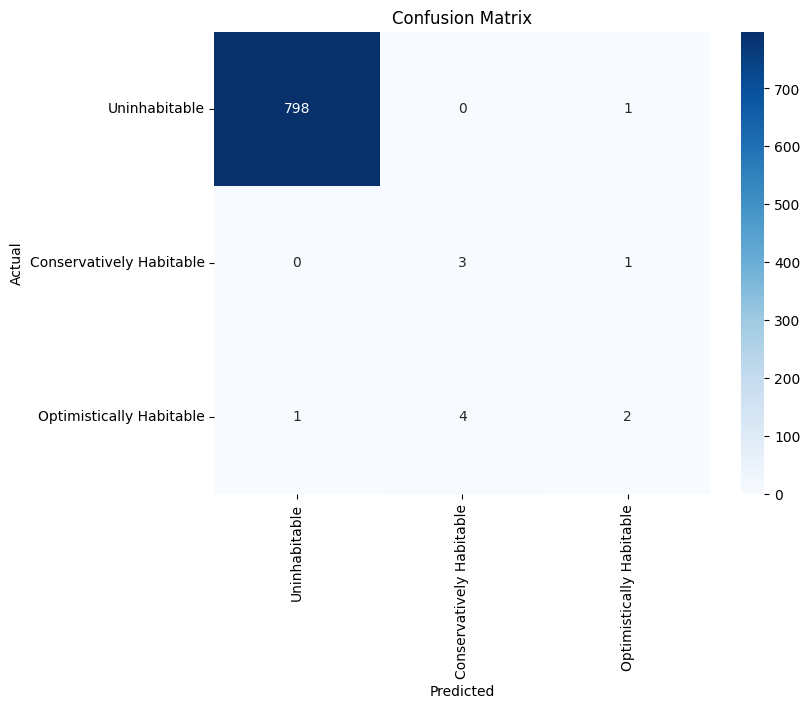

In [6]:
# Generating the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix using seaborn heatmap
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Uninhabitable', 'Conservatively Habitable', 'Optimistically Habitable'], 
    yticklabels=['Uninhabitable', 'Conservatively Habitable', 'Optimistically Habitable'
])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

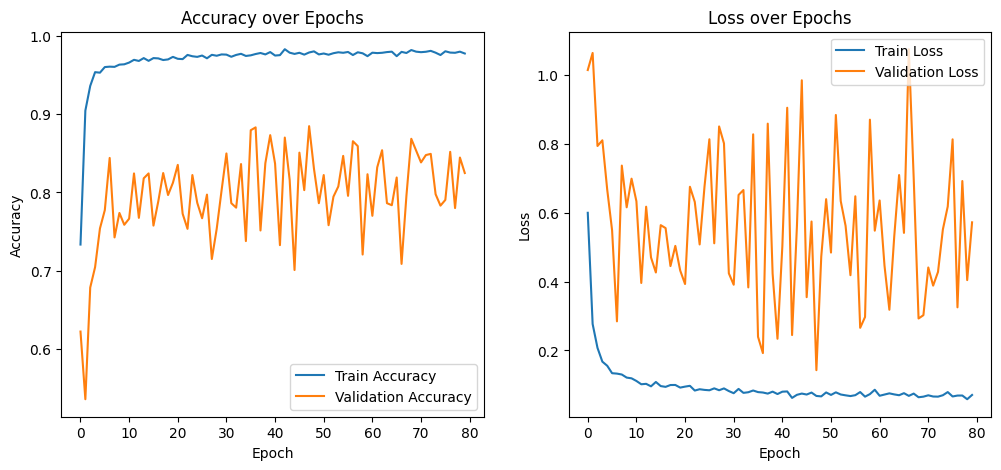

In [7]:
# Plot the accuracy and loss curves
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [8]:
# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# Save the model
model.save('trained_model.h5')